**Pavlos Spanoudakis (sdi1800184)**\
**Theodora Troizi (sdi1800197)**
### Homework 2 on Data Mining Techniques class
## Goodreads Books Recommendation & Classification

In [55]:
### Standard Modules ###

# Type Hints
from typing import Iterable, List, TypedDict, TypeVar, Generic, Callable, Optional
# from typing_extensions import NotRequired #, ParamSpec

import ast
from abc import ABC, abstractmethod
# from datetime import datetime, date, timedelta
# from enum import Enum, auto
# import warnings


### Non-standard Modules ###

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
# 
# ipynb-specific
from IPython.display import display, Markdown
# from tqdm.notebook import tqdm

In [56]:
CSV_PATH = '/books_1.Best_Books_Ever.csv'
USE_GDRIVE = True

def readDataset() -> pd.DataFrame:
    """
        Attempts to read the Dataset from `CSV_PATH`, unless `USE_GDRIVE` is `True`.
        If this is the case and this notebook is running on Google Colab (`google.colab` module is available),
        `CSV_PATH` should be set to a relative path under `/content/gdrive/My Drive/`.
    """

    path = '.'
    if USE_GDRIVE:
        try:
            from google.colab import drive # type: ignore
            drive.mount('/content/gdrive', force_remount=True)
            path = '/content/gdrive/My Drive/'
        except ImportError:
            pass
    
    path += CSV_PATH
    return pd.read_csv(path)

class DataColumn:
    """ Autocomplete (& typo prevention) helper for Column Titles. """

    BOOKID = 'bookId'
    TITLE = 'title'
    SERIES = 'series'
    AUTHOR = 'author'
    RATING = 'rating'
    DESCRIPTION = 'description'
    LANGUAGE = 'language'
    ISBN = 'isbn'
    GENRES = 'genres'
    CHARACTERS = 'characters'
    BOOKFORMAT = 'bookFormat'
    EDITION = 'edition'
    PAGES = 'pages'
    PUBLISHER = 'publisher'
    PUBLISHDATE = 'publishDate'
    FIRSTPUBLISHDATE = 'firstPublishDate'
    AWARDS = 'awards'
    NUMRATINGS = 'numRatings'
    RATINGSBYSTARS = 'ratingsByStars'
    LIKEDPERCENT = 'likedPercent'
    SETTING = 'setting'
    COVERIMG = 'coverImg'
    BBESCORE = 'bbeScore'
    BBEVOTES = 'bbeVotes'
    PRICE = 'price'
    RATINGSTAR1 = 'ratingStar1'
    RATINGSTAR2 = 'ratingStar2'
    RATINGSTAR3 = 'ratingStar3'
    RATINGSTAR4 = 'ratingStar4'
    RATINGSTAR5 = 'ratingStar5'

def printDatasetShape(dataset: pd.DataFrame):
    print(f'Dataset Shape:\nRows: {dataset.shape[0]}, Columns: {dataset.shape[1]}')

def printMd(s: str):
    """ Displays `s` as Markdown text in the output cell. """
    display(Markdown(s))

# TRet = TypeVar('TRet')
# TParams = ParamSpec('TParams')
# def runWithNoWarnings(fn: Callable[TParams, TRet], *args: TParams.args, **kwargs: TParams.kwargs) -> TRet:
#     """ Executes `fn` with the specified `*args` and `**kwargs` while ignoring any raised warnings. """
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore')
#         return fn(*args, **kwargs)

### Dataset Preprocessing

In [57]:
def getFilteredColumns(df: pd.DataFrame, colsToIgnore: Iterable[str]) -> List[str]:
    return [ c for c in df.columns if c not in colsToIgnore ]

def extraDatasetNans(df: pd.DataFrame):
    """
        Returns a single column, boolean `DataFrame`, indicating `df`
        rows that should be considered NaN as well.
    """ 

    return (
        (df[DataColumn.RATINGSBYSTARS] == '[]')
        |
        (df[DataColumn.GENRES] == '[]')
    )

def dropNaNRows(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Drops rows in `df` with NaN values in columns *not* in `colsToIgnore`.
    """

    cols = getFilteredColumns(df, colsToIgnore)

    df.dropna(subset=cols, inplace=True)
    df.drop(df[extraDatasetNans(df)].index, inplace=True)
    df.reset_index(inplace=True, drop=True)

def countMissingByColumn(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Returns a `DataFrame` which includes one row for each column
        of `df` with at least one missing value.
        
        Each row contains the name of the respective column,
        as well as the amount of missing values for that column.
    """

    cols = getFilteredColumns(df, colsToIgnore)
    nans = df[cols].isna().sum()
    extras = df[[DataColumn.RATINGSBYSTARS, DataColumn.GENRES]] 
    extras = (extras[extraDatasetNans(extras)] == '[]').sum()

    total = pd.concat([nans.loc[nans > 0], extras.loc[extras > 0]])
    ret = pd.DataFrame(total.sort_values(ascending=False))
    ret.columns = ['Missing']
    return ret

In [58]:
dataDf = readDataset()
printDatasetShape(dataDf)

Dataset Shape:
Rows: 52478, Columns: 25


In [59]:
colsToIgnore = [
    DataColumn.EDITION,
    DataColumn.SERIES,
    DataColumn.FIRSTPUBLISHDATE,
    DataColumn.PRICE,
    DataColumn.BOOKFORMAT,
    DataColumn.LIKEDPERCENT,
    DataColumn.COVERIMG,
    DataColumn.CHARACTERS
]
countMissingByColumn(dataDf, colsToIgnore)

,Missing
genres,4623
language,3806
publisher,3696
pages,2347
ratingsByStars,1423
description,1338
publishDate,880


In [60]:
dropNaNRows(dataDf, colsToIgnore)
printDatasetShape(dataDf)
countMissingByColumn(dataDf, colsToIgnore)

Dataset Shape:
Rows: 41572, Columns: 25


,Missing


In [61]:
class RatingStarColumns:
    
    starLabels = [
        DataColumn.RATINGSTAR5,
        DataColumn.RATINGSTAR4,
        DataColumn.RATINGSTAR3,
        DataColumn.RATINGSTAR2,
        DataColumn.RATINGSTAR1
    ]
    allLabels = starLabels + [DataColumn.RATINGSBYSTARS]

    @staticmethod
    def extractColumns(df: pd.DataFrame) -> pd.DataFrame:        
        for col in RatingStarColumns.starLabels:
            if col in df.columns:
                return df

        ratingStarArray = np.zeros(shape=(df.shape[0], len(RatingStarColumns.starLabels)), dtype=np.int)
        idxIter = iter(range(df.shape[0]))

        def addRatingStarRow(ratingsByStarsStr: str):
            idx = next(idxIter)
            ratingsList: Iterable[str] = ast.literal_eval(ratingsByStarsStr)
            for j, r in enumerate(ratingsList):
                ratingStarArray[idx][j] = int(r)

        df[DataColumn.RATINGSBYSTARS].apply(addRatingStarRow)

        temp = pd.DataFrame(columns=RatingStarColumns.starLabels, data=ratingStarArray)
        return pd.concat((df, temp), axis=1)
    
    @staticmethod
    def testRatings(df: pd.DataFrame):
        for _, row in df.iterrows():
            a: List[str] = ast.literal_eval(row[DataColumn.RATINGSBYSTARS])
            b = [str(row[col]) for col in (RatingStarColumns.starLabels)]
            if a != b:
                raise AssertionError(f'{a} != {b}')

dataDf = RatingStarColumns.extractColumns(dataDf)
RatingStarColumns.testRatings(dataDf)
dataDf[RatingStarColumns.allLabels].head()

,ratingStar5,ratingStar4,ratingStar3,ratingStar2,ratingStar1,ratingsByStars
0,3444695,1921313,745221,171994,93557,"['3444695', '1921313', '745221', '171994', '93..."
1,1593642,637516,222366,39573,14526,"['1593642', '637516', '222366', '39573', '14526']"
2,2363896,1333153,573280,149952,80794,"['2363896', '1333153', '573280', '149952', '80..."
3,1617567,816659,373311,113934,76770,"['1617567', '816659', '373311', '113934', '767..."
4,1751460,1113682,1008686,542017,548674,"['1751460', '1113682', '1008686', '542017', '5..."


### Data Observation

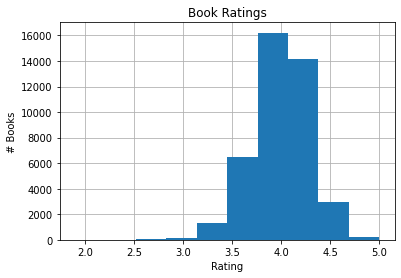

In [62]:
def displayColumnHistogram(df: pd.DataFrame, col: str, xlabel: str, ylabel: str = '# Books', title: str = ''):
    """
        Displays the Histogram for column `col` of `df`.
        - `xlabel`: the label for x-axis.
        - `ylabel`: the label for y-axis.
    """

    ax = plt.subplot()
    ax.set_title(title if title else col)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    df[col].hist(ax=ax, grid=True, zorder=3)

displayColumnHistogram(dataDf, col=DataColumn.RATING, xlabel='Rating', title='Book Ratings')

In [63]:
class AnswerGeneratorQuestion(TypedDict):
    """ Used to store question-specific information. """
    
    qnum: str
    """ Question Number. """
    qtitle: str
    """ Question Title. """
    col: str
    """ Column title. """
    limit: Optional[int]
    """ Limit for number of results. """

QT = TypeVar("QT", bound=AnswerGeneratorQuestion)
class AnswerGenerator(ABC, Generic[QT]):
    """
        Used to generate `DataFrame` answers on Dataset-related questions.
    """
    def __init__(self) -> None:
        self.questions: List[QT] = []

    def registerQuestions(self, questions: Iterable[QT]):
        self.questions = list(questions)
        return self

    def registerQuestion(self, q: QT):
        self.questions.append(q)
        return self

    def clearQuestions(self):
        self.questions.clear()
        return self    
    
    @staticmethod
    @abstractmethod
    def createDataFrameAnswer(df: pd.DataFrame, q: QT):
        pass

    def generateAnswers(self, df: pd.DataFrame):
        """
            Displays the answer for each question provided to the
            `AnswerGenerator`, using data in `df`.

            The answer includes an inline markdown string,
            as well as the results `DataFrame`.
        """
        
        for q in self.questions:
            printMd(f'**{q["qnum"]}**. {q["qtitle"]}:')
            display(self.createDataFrameAnswer(df, q))

In [64]:
class TopBooksQuestion(AnswerGeneratorQuestion):
    """ Used to store question-specific information. """
    
    dataFilter: Optional[ Callable[[pd.DataFrame], pd.DataFrame] ]

class TopBooksAnswerGenerator(AnswerGenerator[TopBooksQuestion]):
    """
        Used to generate `DataFrame` answers on questions regarding
        the top books based on a specific column value.
    """ 
    
    @staticmethod
    def createDataFrameAnswer(df: pd.DataFrame, q: TopBooksQuestion):
        filter = q['dataFilter']
        df = filter(dataDf) if filter else df

        limit = q['limit'] if q['limit'] else df.shape[0]

        results = df.sort_values(by=q['col'], ascending=False).head(n=limit)
        return results[[DataColumn.TITLE, q['col']]]
        

In [65]:
questions: List[TopBooksQuestion] = [
    {
        'qnum': '2',
        'qtitle': 'Top 10 books with the most pages',
        'col': DataColumn.PAGES,
        'limit': 10,
        'dataFilter': None
    },
    {
        'qnum': '3',
        'qtitle': 'Top 10 books with the most 5-star ratings (min 10000)',
        'col': DataColumn.RATINGSTAR5,
        'limit': 10,
        'dataFilter': lambda df: df[df[DataColumn.RATINGSTAR5] > 10000]
    },
]
(
    TopBooksAnswerGenerator()
        .registerQuestions(questions)
        .generateAnswers(dataDf)
)

**2**. Top 10 books with the most pages:

,title,pages
30698,The Marx Sisters: A Kathy Kolla and David Broc...,999
304,The Wise Man's Fear,994
656,A Breath of Snow and Ashes,993
35898,Hamzanama: The Adventures of Amir Hamza,992
27195,The Ball is Round: A Global History of Soccer,992
14843,The Endymion Omnibus,992
11779,The Braided Path,992
17695,Three Novels of Old New York: The House of Mir...,992
12217,The Last Lion: Winston Spencer Churchill: Visi...,992
36110,"1,000 Places to See Before You Die",992


**3**. Top 10 books with the most 5-star ratings (min 10000):

,title,ratingStar5
32,Harry Potter and the Sorcerer's Stone,4578137
0,The Hunger Games,3444695
2,To Kill a Mockingbird,2363896
71,Harry Potter and the Deathly Hallows,2038930
93,Harry Potter and the Prisoner of Azkaban,1892635
10,The Fault in Our Stars,1784471
4,Twilight,1751460
103,Harry Potter and the Goblet of Fire,1729403
105,Harry Potter and the Half-Blood Prince,1646703
3,Pride and Prejudice,1617567


In [66]:
# temp = dataDf[[DataColumn.TITLE, DataColumn.RATINGSTAR5, DataColumn.PAGES]]

In [67]:
class ColumnTopValuesAnswerGenerator(AnswerGenerator[AnswerGeneratorQuestion]):
    """
        Used to generate `DataFrame` answers on questions regarding
        the most popular values in columns.
    """ 
    
    @staticmethod
    def createDataFrameAnswer(df: pd.DataFrame, q: AnswerGeneratorQuestion):
        pass

In [68]:
questions: List[AnswerGeneratorQuestion] = [
    {
        'qnum': 'Q6.14',
        'qtitle': '',
        'col': DataColumn.AUTHOR,
        'limit': 0,
    },
    {
        'qnum': 'Q6.14',
        'qtitle': '',
        'col': DataColumn.AUTHOR,
        'limit': 0
    },
]
(
    ColumnTopValuesAnswerGenerator()
        .registerQuestions(questions)
        .generateAnswers(dataDf)
)

**Q6.14**. :

None

**Q6.14**. :

None

In [69]:
#authors = dataDf[DataColumn.AUTHOR]